In [1]:
import io 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ssv2.simulation import BaseSimulation

Let's start by visualizing some little simulations.

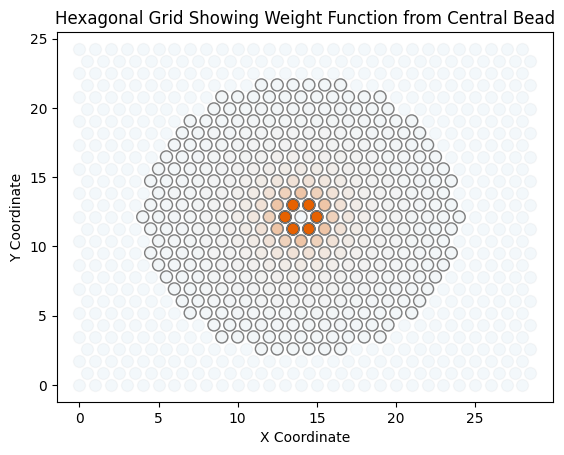

In [2]:
# joint_sums gives counts of source and target reads. Here we just want 20 reads for source and target.
joint_sums = pd.DataFrame({"row_sums": [20], "col_sums": [20]})
simulator = BaseSimulation(29, 29, max_dispersion_radius=10, max_dispersion_scale=10, joint_sums=joint_sums)

simulator.plot_setting()

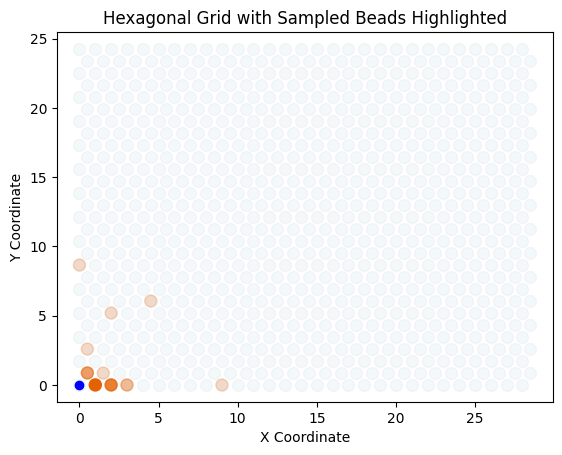

In [3]:
_ = simulator.plot_sample(0)

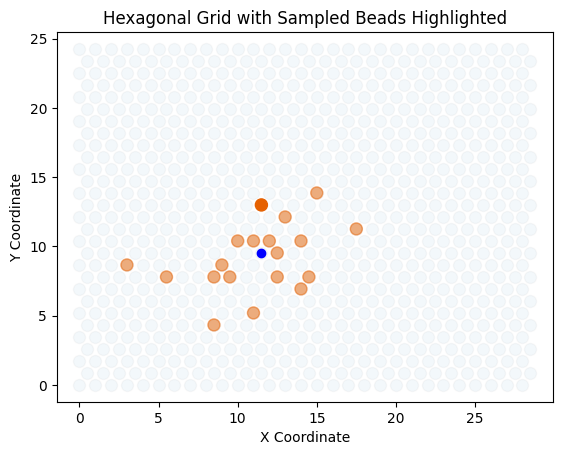

In [4]:
_ = simulator.plot_sample(330)

In [5]:
from PIL import Image

# Generate frames
frames = []
for _ in range(20):
    # This assumes your plot_sample function returns a Figure object
    fig = simulator.plot_sample(130)
    # Convert the Figure object to a PIL Image
    buf = io.BytesIO()
    fig.savefig(buf, format="png")
    buf.seek(0)
    frame = Image.open(buf)
    frames.append(frame)
    plt.close(fig)  # Close the figure after using it

# Save as an animated GIF
frames[0].save(
    '../_ignore/animation.gif',
    save_all=True, append_images=frames[1:], optimize=False, duration=500, loop=0
)

## Big simulation!

In [6]:
real_counts = pd.read_csv("../_data/nextera_interactions_filtered.csv.gz")
pivot = real_counts.pivot(index='row_idx', columns='col_idx', values='read_count')

row_sums = pivot.sum(axis=1)
col_sums = pivot.sum(axis=0)

joint_sums = pd.DataFrame({'row_sums': row_sums, 'col_sums': col_sums}, dtype=int)
joint_sums.to_csv('../_data/nextera_interactions_filtered_joint_sums.csv', index=False)

In [7]:
simulator = BaseSimulation(197, 197, max_dispersion_radius=50, max_dispersion_scale=50, joint_sums=joint_sums)
simulated_beads_df = simulator.simulate_experiment()
simulated_beads_df.to_csv('../_data/sim.nextera_interactions_filtered.csv.gz', index=False, compression='gzip')

100%|██████████| 38809/38809 [02:41<00:00, 240.10it/s]


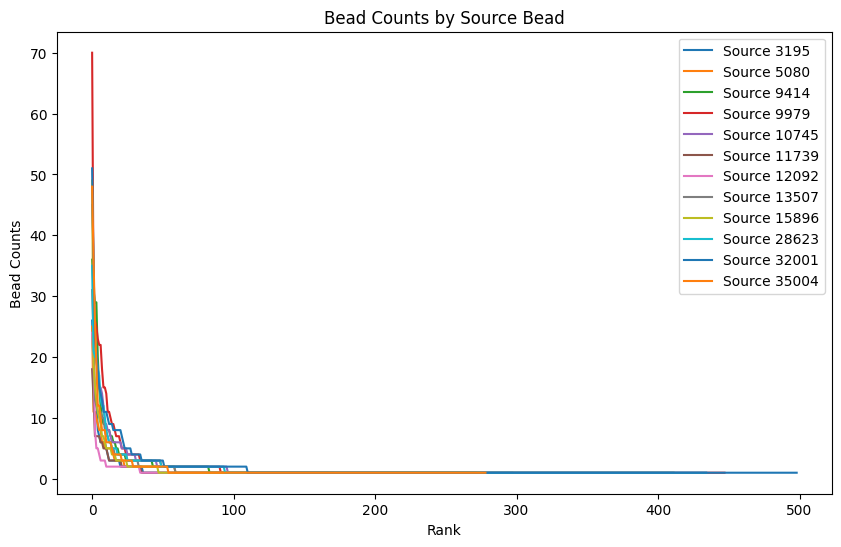

In [8]:
sampled_source_beads = simulated_beads_df['source_bead'].sample(12).unique()
df = simulated_beads_df[simulated_beads_df['source_bead'].isin(sampled_source_beads)]

# Plotting
plt.figure(figsize=(10,6))

for source, group in df.groupby('source_bead'):
    sorted_group = group.sort_values(by='bead_counts', ascending=False)
    plt.plot(sorted_group['bead_counts'].values, label=f'Source {source}')

plt.ylabel('Bead Counts')
plt.xlabel('Rank')
plt.title('Bead Counts by Source Bead')
plt.legend()
plt.show()

In [9]:
pivot = simulated_beads_df.pivot(index='source_bead', columns='target_bead', values='bead_counts')

unique_source = simulated_beads_df['source_bead'].unique()
unique_target = simulated_beads_df['target_bead'].unique()

all_beads = pd.Index(np.union1d(unique_source, unique_target))

counts = pivot.reindex(index=all_beads, columns=all_beads)

counts.fillna(0, inplace=True)
counts = counts.astype(int)


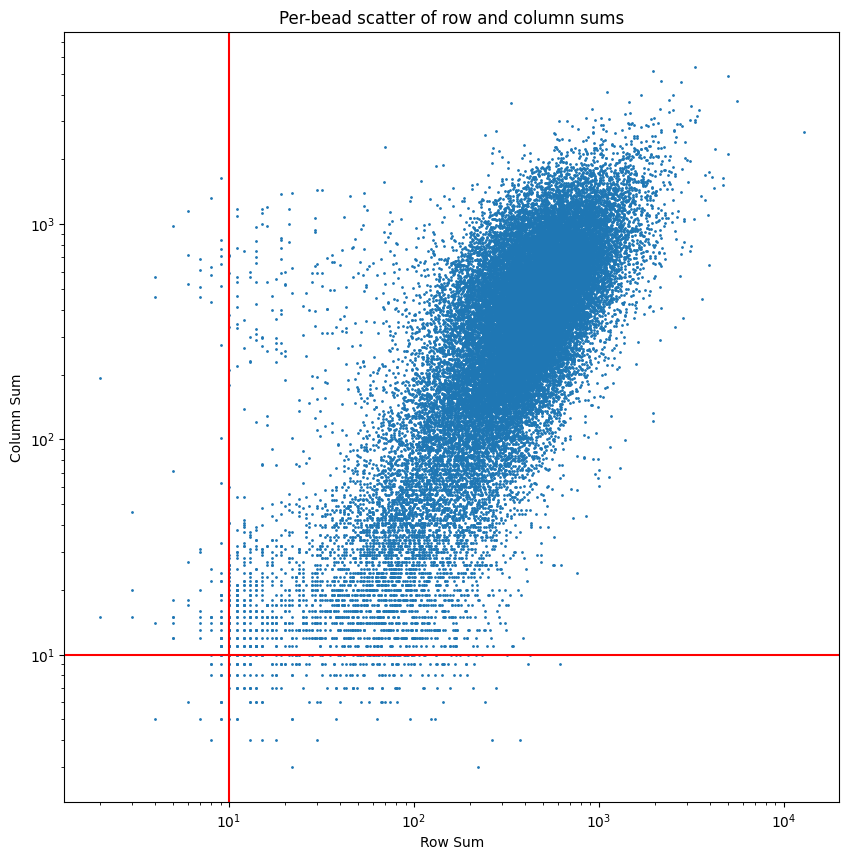

In [10]:
row_sums = counts.sum(axis=1)
col_sums = counts.sum(axis=0)

plt.figure(figsize=(10, 10))
plt.title('Per-bead scatter of row and column sums')
plt.xlabel('Row Sum')
plt.ylabel('Column Sum')
plt.scatter(row_sums, col_sums, s=1)
plt.yscale('log')
plt.xscale('log')
plt.axvline(x=10, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='-')
plt.show()

In [11]:
simulator.add_coords(simulator.bead_df).to_csv('../_data/sim.nextera_interactions_filtered.coords.csv')